# The Battle of Neighborhoods : Finding a Familiar Neighborhood

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

In [2]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

#### Extracting n preparing Canada dataset

In [3]:
txt=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table')
df_ca=pd.DataFrame(columns=['PostalCode','Borough','Neighborhood'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_ca.loc[len(df_ca)]=row
df_ca.drop(0, inplace=True)
df_ca.drop(df_ca[df_ca['Borough']=='Not assigned'].index, inplace=True)
df_ca=df_ca.groupby(['PostalCode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_ca=df_ca.reset_index()
df_ca.loc[df_ca['Neighborhood'] =='Not assigned', 'Neighborhood'] = df_ca['Borough']
df_geo=pd.read_csv('https://cocl.us/Geospatial_data')
df_geo.columns=['PostalCode', 'Latitude', 'Longitude']
df_ca=df_ca.merge(df_geo, on='PostalCode')
df_ca.drop("PostalCode", inplace=True, axis=1)
print(df_ca['Borough'].value_counts())
print(df_ca.shape)
df_ca.head()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Mississauga          1
Name: Borough, dtype: int64
(103, 4)


Borough                                 Neighborhood   Latitude  \
0        North York                                    Parkwoods  43.753259   
1        North York                             Victoria Village  43.725882   
2  Downtown Toronto                    Regent Park, Harbourfront  43.654260   
3        North York             Lawrence Manor, Lawrence Heights  43.718518   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

#### Extracting n preparing New York dataset

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
df_ny=neighborhoods
df_ny.drop(df_ny[df_ny['Borough']=='Queens'].index, inplace=True)
df_ny.drop(df_ny[df_ny['Borough']=='Brooklyn'].index, inplace=True)
df_ny.reset_index(inplace=True)
df_ny.drop('index', axis=1, inplace=True)
print(df_ny['Borough'].value_counts())
print(df_ny.shape)
df_ny.head()

Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64
(155, 4)


Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

#### Extracting n preparing Bangalore dataset

In [6]:
txt=requests.get('https://www.indiatvnews.com/pincode/karnataka/bangalore/').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table')
df_blr=pd.DataFrame(columns=['Neighborhood','Borough','district','state','pincode'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_blr.loc[len(df_blr)]=row
df_blr.drop(0, inplace=True)
df_blr.drop(df_blr[df_blr['Borough']=='NA'].index, inplace=True)
df_blr=df_blr.groupby(['pincode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_blr=df_blr.reset_index()
df_blr.loc[df_blr['Neighborhood'] =='NA', 'Neighborhood'] = df_blr['Borough']
df=pd.DataFrame(columns=['pincode','Latitude', 'Longitude'])
for pincode in df_blr['pincode']:
    address = str(pincode)+', Bangalore, Karnataka, India'
    geolocator = Nominatim(user_agent="kk_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_blr=df_blr.merge(df, on='pincode')
df_blr.drop_duplicates(inplace=True)
df_blr.drop(df_blr[df_blr['Latitude']=='NA'].index, inplace=True)
df_blr.drop('pincode', axis=1, inplace=True)
df_blr.reset_index(inplace=True)
df_blr.drop('index', axis=1, inplace=True)
print(df_blr['Borough'].value_counts())
print(df_blr.shape)
df_blr.head()

Bangalore North    62
Bangalore South    39
Bangalore           9
Anekal              5
Bg North            2
Bgnorth             1
Bangalore north     1
Banglore            1
Bgsouth             1
Magadi              1
Devanahalli         1
Bangaloresouth      1
Nla & Bgsouth       1
Banglorenorth       1
Bg South            1
Name: Borough, dtype: int64
(127, 4)


Borough                                       Neighborhood  \
0  Bangalore North         A F Station Yelahanka,BSF Campus Yelahanka   
1  Bangalore South                                              Agram   
2  Bangalore North                                 Air Force Hospital   
3  Bangalore North  Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...   
4  Bangalore North    Anandnagar Bangalore,H.A. Farm,Hebbal Kempapura   

  Latitude Longitude  
0  12.8987   77.6393  
1  12.9686   77.6303  
2  12.9686   77.6303  
3  13.0603   77.5842  
4  13.0237   77.5844

#### Extracting n preparing Hyderabad dataset

In [7]:
txt=requests.get('https://www.indiatvnews.com/pincode/telangana/hyderabad').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table')
df_hyd=pd.DataFrame(columns=['Neighborhood','Borough','district','state','pincode'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_hyd.loc[len(df_hyd)]=row
df_hyd.drop(0, inplace=True)
df_hyd.drop(df_hyd[df_hyd['Borough']=='NA'].index, inplace=True)
df_hyd=df_hyd.groupby(['pincode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_hyd=df_hyd.reset_index()
df_hyd.loc[df_hyd['Neighborhood'] =='NA', 'Neighborhood'] = df_hyd['Borough']
df=pd.DataFrame(columns=['pincode','Latitude', 'Longitude'])
for pincode in df_hyd['pincode']:
    address = str(pincode)+', Hyderabad, Telangana, India'
    geolocator = Nominatim(user_agent="ny_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_hyd=df_hyd.merge(df, on='pincode')
df_hyd.drop_duplicates(inplace=True)
df_hyd.drop(df_hyd[df_hyd['Latitude']=='NA'].index, inplace=True)
df_hyd.drop('pincode', axis=1, inplace=True)
df_hyd.reset_index(inplace=True)
df_hyd.drop('index', axis=1, inplace=True)
print(df_hyd['Borough'].value_counts())
print(df_hyd.shape)
df_hyd.head()

Tirumalagiri           21
Secunderabad           12
Hyderabad              11
Hyd                     8
Khairatabad             7
Nampally                6
Rajendranagar           6
Charminar               6
Himayathnagar           4
Rangareddy              4
Golconda                3
Saidabad                3
Asifnagar               3
Saroornagar             3
Shaikpet                3
Bandlaguda              3
Serilingampally         2
Uppal                   2
Hayathnagar             2
Ameerpet                2
Amberpet                2
Ghatkesar               2
Musheerabad             2
Balanagar               2
Shamirpet Mandal        1
Seri Lingampally        1
Rajendra Nagar          1
Vikarabad               1
Bahadurpura             1
Malkagiri Manda         1
Quthbullapur Mandal     1
saroornagar             1
Qutubullapur            1
Name: Borough, dtype: int64
(128, 4)


Borough                                       Neighborhood Latitude  \
0     Khairatabad  A.Gs Office,Anandnagar Hyderabad,Bazarghat Hyd...  17.3962   
1   Himayathnagar                                   Parishram Bhawan  17.3962   
2        Nampally                             Vidhan Sabha Hyderabad  17.3962   
3     Khairatabad                    A.Gs. Staff Quarters,Yousufguda  17.4374   
4  Rajendra Nagar                               AP Police Academy PO   17.528   

  Longitude  
0   78.4631  
1   78.4631  
2   78.4631  
3    78.428  
4    78.267

#### Extracting n preparing Mumbai dataset

In [8]:
txt=requests.get('https://www.indiatvnews.com/pincode/maharashtra/mumbai').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table')
df_bom=pd.DataFrame(columns=['Neighborhood','Borough','district','state','pincode'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_bom.loc[len(df_bom)]=row
df_bom.drop(0, inplace=True)
df_bom.drop(df_bom[df_bom['Borough']=='NA'].index, inplace=True)
df_bom=df_bom.groupby(['pincode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_bom=df_bom.reset_index()
df_bom.loc[df_bom['Neighborhood'] =='NA', 'Neighborhood'] = df_bom['Borough']
df=pd.DataFrame(columns=['pincode','Latitude', 'Longitude'])
for pincode in df_bom['pincode']:
    address = str(pincode)+', Mumbai, Maharashtra, India'
    geolocator = Nominatim(user_agent="ny_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_bom=df_bom.merge(df, on='pincode')
df_bom.drop_duplicates(inplace=True)
df_bom.drop(df_bom[df_bom['Latitude']=='NA'].index, inplace=True)
df_bom.drop('pincode', axis=1, inplace=True)
df_bom.reset_index(inplace=True)
df_bom.drop('index', axis=1, inplace=True)
print(df_bom['Borough'].value_counts())
print(df_bom.shape)
df_bom.head()

Mumbai             54
Borivali West       3
Goregaon East       2
Malad West          2
Jogeshwari East     2
Dahisar East        1
Goregaon West       1
Kandivali West      1
Jogeshwari West     1
Borivali East       1
Dahisar West        1
Kandivlai West      1
Kandivali East      1
Bandra              1
Malad East          1
Borivlai East       1
Name: Borough, dtype: int64
(74, 4)


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Borough                                       Neighborhood   Latitude  \
0  Mumbai               Antop Hill,B P T Colony,C G S Colony  19.023074   
1  Mumbai  Chamarbaug,Haffkin Institute,Lal Baug,Parel Na...  18.996311   
2  Mumbai  Cotton Exchange,Kalachowki,L B S N E collage,R...  18.938771   
3  Mumbai                  Dadar Colony,Dadar,Naigaon Mumbai  19.010619   
4  Mumbai  Dockyard Road,Mazgaon Dock,Mazgaon Road,Mazgao...  18.968523   

   Longitude  
0  72.867622  
1  72.842493  
2  72.835335  
3  72.846936  
4  72.837844

#### Extracting n preparing Pune dataset

In [9]:
txt=requests.get('https://www.indiatvnews.com/pincode/maharashtra/pune').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table')
df_pnq=pd.DataFrame(columns=['Neighborhood','Borough','district','state','pincode'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_pnq.loc[len(df_pnq)]=row
df_pnq.drop(0, inplace=True)
df_pnq.drop(df_pnq[df_pnq['Borough']=='NA'].index, inplace=True)
df_pnq=df_pnq.groupby(['pincode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_pnq=df_pnq.reset_index()
df_pnq.loc[df_pnq['Neighborhood'] =='NA', 'Neighborhood'] = df_pnq['Borough']
df=pd.DataFrame(columns=['pincode','Latitude', 'Longitude'])
for pincode in df_pnq['pincode']:
    address = str(pincode)+', Pune, Maharashtra, India'
    geolocator = Nominatim(user_agent="ny_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_pnq=df_pnq.merge(df, on='pincode')
df_pnq.drop_duplicates(inplace=True)
df_pnq.drop(df_pnq[df_pnq['Latitude']=='NA'].index, inplace=True)
df_pnq.drop('pincode', axis=1, inplace=True)
df_pnq.reset_index(inplace=True)
df_pnq.drop('index', axis=1, inplace=True)
print(df_pnq['Borough'].value_counts())
print(df_pnq.shape)
df_pnq.head()

Pune City    51
Haveli       24
Ambegaon     11
Baramati     11
Daund        10
Maval         9
Shirur        9
Khed          8
Indapur       8
Junnar        8
Purandar      7
Mulshi        6
Velhe         3
Bhor          3
Mawal         3
Purandhar     2
Pune          2
Shiurur       1
Mulashi       1
Name: Borough, dtype: int64
(177, 4)


Borough                              Neighborhood Latitude Longitude
0  Pune City            9 DRD,Dukirkline,Vadgaon Sheri  18.5628   73.9137
1       Pune                               Viman nagar  18.5628   73.9137
2  Pune City                            AFMC,Wanowarie  18.4838   73.9013
3  Pune City  Airport Pune,Iaf Station,Vidyanagar Pune  18.5832   73.9008
4  Pune City                                    Akurdi  18.7621   73.9526

#### Extracting n preparing Delhi dataset

In [10]:
txt1=requests.get('https://www.indiatvnews.com/pincode/delhi/central-delhi').text
txt2=requests.get('https://www.indiatvnews.com/pincode/delhi/east-delhi').text
txt3=requests.get('https://www.indiatvnews.com/pincode/delhi/new-delhi').text
txt4=requests.get('https://www.indiatvnews.com/pincode/delhi/north-delhi').text
txt5=requests.get('https://www.indiatvnews.com/pincode/delhi/north-east-delhi').text
txt6=requests.get('https://www.indiatvnews.com/pincode/delhi/north-west-delhi').text
txt7=requests.get('https://www.indiatvnews.com/pincode/delhi/south-delhi').text
txt8=requests.get('https://www.indiatvnews.com/pincode/delhi/south-west-delhi').text
txt9=requests.get('https://www.indiatvnews.com/pincode/delhi/west-delhi').text
soup=BeautifulSoup(txt1, 'lxml')
table=soup.find('table')
df_del=pd.DataFrame(columns=['Neighborhood','Borough','district','state','pincode'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt2, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt3, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt4, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt5, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt6, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt7, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt8, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

soup=BeautifulSoup(txt9, 'lxml')
table=soup.find('table')
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_del.loc[len(df_del)]=row

df_del.drop(df_del[df_del['Borough']=='Taluk'].index, inplace=True)
df_del.drop(df_del[df_del['Borough']=='NA'].index, inplace=True)
df_del=df_del.groupby(['pincode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_del=df_del.reset_index()
df_del.loc[df_del['Neighborhood'] =='NA', 'Neighborhood'] = df_del['Borough']
df=pd.DataFrame(columns=['pincode','Latitude', 'Longitude'])
for pincode in df_del['pincode']:
    address = str(pincode)+', Delhi, India'
    geolocator = Nominatim(user_agent="ny_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_del=df_del.merge(df, on='pincode')
df_del.drop_duplicates(inplace=True)
df_del.drop(df_del[df_del['Latitude']=='NA'].index, inplace=True)
df_del.drop('pincode', axis=1, inplace=True)
df_del.reset_index(inplace=True)
df_del.drop('index', axis=1, inplace=True)
print(df_del['Borough'].value_counts())
print(df_del.shape)
df_del.head()

New Delhi           44
Delhi               23
North                2
South West Delhi     2
East Delhi           1
North West Delhi     1
South Delhi          1
Delhi North East     1
Name: Borough, dtype: int64
(75, 4)


Borough                                       Neighborhood Latitude  \
0  New Delhi  A.G.C.R.,Ajmeri Gate Extn.,Darya Ganj,Gandhi S...   28.641   
1  New Delhi  A.K.Market,Multani Dhanda,Pahar Ganj,Swami Ram...  28.6525   
2  New Delhi  Anand Parbat Indl. Area,Anand Parbat,Bank Stre...  28.6505   
3  New Delhi  Baroda House,Bengali Market,Bhagat Singh Marke...  28.6517   
4  New Delhi  Dada Ghosh Bhawan,Patel Nagar East,Patel Nagar...  28.6562   

  Longitude  
0   77.2455  
1   77.2134  
2    77.189  
3   77.2219  
4   77.1625

#### Extracting n preparing Paris dataset

In [11]:
df_idf = pd.DataFrame(pd.read_json('https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e'))
df_idf_r = pd.DataFrame()
for m in df_idf.fields:
    dict_new = m
    df_idf_r = df_idf_r.append(dict_new, ignore_index=True)
df_paris = df_idf_r[df_idf_r["nom_dept"] == "PARIS"].reset_index(drop = True)
df_paris.sort_values(by = 'postal_code',axis = 0, ascending = True, inplace = True)
df_paris = df_paris[['nom_comm','postal_code']].reset_index(drop = True)
df_paris = df_paris.rename(columns = {"nom_comm":"num_arr"})
df_paris['Borough']=df_paris['num_arr']
df_paris.loc[0:8,'num_arr'] = df_paris.loc[0:8,"num_arr"].str[6:7].astype(int)
df_paris.loc[9:,'num_arr'] = df_paris.loc[9:,"num_arr"].str[6:8].astype(int)
df_Q = pd.DataFrame(pd.read_json('https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=json&timezone=Europe/Berlin'))
df_quartier = pd.DataFrame()
for q in df_Q.fields:
    dict_new = q
    df_quartier = df_quartier.append(dict_new, ignore_index=True)
df_quartier = df_quartier.rename(columns = {"c_ar":"num_arr","c_qu":"num_quartier","c_quinsee":"num_insee_quartier","l_qu":"quartier"})
convert_dict = {'num_arr': int}
df_quartier = df_quartier.astype(convert_dict)
df_par=df_paris.merge(df_quartier, on='num_arr')
df_par.drop(['num_arr','num_quartier','num_insee_quartier','geom','n_sq_ar','n_sq_qu','perimetre','surface'], axis=1, inplace=True)
df_par=df_par.rename(columns = {"quartier":"Neighborhood"})
c=0
for i in df_par['geom_x_y']:
    df_par.loc[c,'Latitude']=i[0]
    df_par.loc[c,'Longitude']=i[1]
    c=c+1
df_par.drop(['postal_code','geom_x_y'], axis=1, inplace=True)
print(df_par['Borough'].value_counts())
print(df_par.shape)
df_par.head()

PARIS-17E-ARRONDISSEMENT    4
PARIS-13E-ARRONDISSEMENT    4
PARIS-4E-ARRONDISSEMENT     4
PARIS-14E-ARRONDISSEMENT    4
PARIS-20E-ARRONDISSEMENT    4
PARIS-3E-ARRONDISSEMENT     4
PARIS-6E-ARRONDISSEMENT     4
PARIS-19E-ARRONDISSEMENT    4
PARIS-8E-ARRONDISSEMENT     4
PARIS-16E-ARRONDISSEMENT    4
PARIS-11E-ARRONDISSEMENT    4
PARIS-9E-ARRONDISSEMENT     4
PARIS-1ER-ARRONDISSEMENT    4
PARIS-12E-ARRONDISSEMENT    4
PARIS-15E-ARRONDISSEMENT    4
PARIS-18E-ARRONDISSEMENT    4
PARIS-10E-ARRONDISSEMENT    4
PARIS-7E-ARRONDISSEMENT     4
PARIS-2E-ARRONDISSEMENT     4
PARIS-5E-ARRONDISSEMENT     4
Name: Borough, dtype: int64
(80, 4)


Borough               Neighborhood   Latitude  Longitude
0  PARIS-1ER-ARRONDISSEMENT                     Halles  48.862289   2.344899
1  PARIS-1ER-ARRONDISSEMENT               Palais-Royal  48.864660   2.336309
2  PARIS-1ER-ARRONDISSEMENT  Saint-Germain-l'Auxerrois  48.860650   2.334910
3  PARIS-1ER-ARRONDISSEMENT              Place-Vendôme  48.867019   2.328582
4   PARIS-2E-ARRONDISSEMENT                   Vivienne  48.869100   2.339461

#### Extracting n preparing London dataset

In [12]:
txt=requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London').text
soup=BeautifulSoup(txt, 'lxml')
table=soup.find('table', {'class':'wikitable sortable'}).tbody
df_ldn=pd.DataFrame(columns=['Neighborhood','Borough','PostTown','Postcode','Dialcode','os grid'])
for tr in table.find_all('tr'):
    row=[]
    for td in tr.find_all('th') or tr.find_all('td'):
        row.append(td.text.strip())
    df_ldn.loc[len(df_ldn)]=row
df_ldn.drop(0, inplace=True)
df_ldn['Borough'] = df_ldn['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))
df_ldn = df_ldn.drop('Postcode', axis=1).join(df_ldn['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))
df_ldn = df_ldn[['Neighborhood', 'Borough', 'Postcode', 'PostTown']].reset_index(drop=True)
df_ldn.drop(df_ldn[df_ldn['PostTown']!='LONDON'].index, inplace=True)
df_ldn.reset_index(inplace=True)
df_ldn.drop('index', axis=1, inplace=True)
df_ldn=df_ldn.groupby(['Postcode','Borough'], sort=False)['Neighborhood'].apply(lambda x: "%s" % ','.join(x))
df_ldn=df_ldn.reset_index()
df=pd.DataFrame(columns=['Postcode','Latitude', 'Longitude'])
for pincode in df_ldn['Postcode']:
    address = str(pincode)+', London, United Kingdom'
    geolocator = Nominatim(user_agent="ny_explorer", timeout=10)
    location = geolocator.geocode(address)
    if hasattr(location,'latitude') and hasattr(location,'longitude'):
        row=[pincode,location.latitude, location.longitude]
    else:
        row=[pincode,'NA', 'NA']
    df.loc[len(df)]=row
df_ldn=df_ldn.merge(df, on='Postcode')
df_ldn.drop_duplicates(inplace=True)
df_ldn.drop(df_ldn[df_ldn['Latitude']=='NA'].index, inplace=True)
df_ldn.drop('Postcode', axis=1, inplace=True)
df_ldn.reset_index(inplace=True)
df_ldn.drop('index', axis=1, inplace=True)
print(df_ldn['Borough'].value_counts())
print(df_ldn.shape)
df_ldn.head()

Barnet                                          15
Hackney                                         13
Kensington and Chelsea                          12
Camden                                          11
Lambeth                                         11
Haringey                                        10
Lewisham                                         9
Southwark                                        9
Newham                                           8
Westminster                                      7
Wandsworth                                       7
Enfield                                          7
Greenwich                                        6
Islington                                        6
Brent                                            6
Bromley                                          5
Ealing                                           5
Hammersmith and Fulham                           5
Waltham Forest                                   5
Tower Hamlets                  

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Borough          Neighborhood   Latitude  Longitude
0             Bexley,  Greenwich             Abbey Wood  51.489708   0.120957
1                          Bexley  Crossness,West Heath  51.489708   0.120957
2  Ealing, Hammersmith and Fulham                 Acton  51.507322  -0.127647
3  Ealing, Hammersmith and Fulham                 Acton  51.507322  -0.127647
4                            City               Aldgate  51.507322  -0.127647

#### Extracting n preparing Beijing dataset

In [13]:
df_bj = pd.read_csv('https://raw.githubusercontent.com/biqiongyu/Battle-of-Neighborhoods/master/bj_neighborhoods.csv', sep="\t")
df_bj.drop(['Unnamed: 0','City'], axis=1, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Pinggu'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Mentougou'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Yanqing'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Shunyi'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Shijingshan'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Changping'].index, inplace=True)
df_bj.drop(df_bj[df_bj['Borough']=='Tongzhou'].index, inplace=True)
df_bj.reset_index(inplace=True)
df_bj.drop('index', axis=1, inplace=True)
print(df_bj['Borough'].value_counts())
print(df_bj.shape)
df_bj.head()

Chaoyang     38
Haidian      23
Daxing       16
Dongcheng    15
Fangshan     15
Fengtai      14
Huairou      12
Xicheng      11
Miyun        11
Name: Borough, dtype: int64
(155, 4)


Borough  Neighborhood   Latitude   Longitude
0  Chaoyang       Jianwai  39.903632  116.447743
1  Chaoyang       Chaowai  39.920678  116.431470
2  Chaoyang      Hujialou  39.921918  116.455520
3  Chaoyang      Sanlitun  39.936105  116.448813
4  Chaoyang  Zuojiazhuang  39.956302  116.438899

#### Extracting n preparing Shanghai dataset

In [14]:
df_sh = pd.read_csv('https://raw.githubusercontent.com/biqiongyu/Battle-of-Neighborhoods/master/sh_neighborhoods.csv', sep="\t")
df_sh.drop(['Unnamed: 0','City'], axis=1, inplace=True)
df_sh.drop(df_sh[df_sh['Borough']=='Putuo'].index, inplace=True)
df_sh.drop(df_sh[df_sh['Borough']=='Hongkou'].index, inplace=True)
df_sh.drop(df_sh[df_sh['Borough']=='Jiading'].index, inplace=True)
df_sh.drop(df_sh[df_sh['Borough']=='Huangpu'].index, inplace=True)
df_sh.drop(df_sh[df_sh['Borough']=='Changning'].index, inplace=True)
df_bj.reset_index(inplace=True)
df_bj.drop('index', axis=1, inplace=True)
print(df_sh['Borough'].value_counts())
print(df_sh.shape)
df_sh.head()

Pudong       38
Songjiang    19
Xuhui        14
Baoshan      12
Minhang      12
Qingpu       11
Yangpu       10
Fengxian     10
Jingan       10
Chongming     9
Jinshan       9
Name: Borough, dtype: int64
(154, 4)


Borough Neighborhood   Latitude   Longitude
0  Baoshan       Wusong  31.374707  121.489410
1  Baoshan        Youyi  31.405927  121.471382
2  Baoshan    Zhangmiao  31.335766  121.440917
3  Baoshan      Dachang  31.294144  121.412396
4  Baoshan      Gaojing  31.323159  121.477525

### Now let us combine all the data sets of all the places into one dataframe to analyze the similarity between them together

In [25]:
df_f=pd.concat([df_ca,df_ny,df_blr,df_hyd,df_bom,df_pnq,df_del,df_par,df_ldn,df_sh,df_bj])
df_f.reset_index(inplace=True)
df_f.drop('index', axis=1, inplace=True)
print(df_f['Borough'].value_counts())
print(df_f.shape)
df_f.head()

Staten Island                                   63
Bangalore North                                 62
Mumbai                                          54
Bronx                                           52
Pune City                                       51
New Delhi                                       44
Manhattan                                       40
Bangalore South                                 39
Pudong                                          38
Chaoyang                                        38
North York                                      24
Haveli                                          24
Delhi                                           23
Haidian                                         23
Tirumalagiri                                    21
Songjiang                                       19
Downtown Toronto                                19
Scarborough                                     17
Daxing                                          16
Dongcheng                      

Borough                                 Neighborhood Latitude  \
0        North York                                    Parkwoods  43.7533   
1        North York                             Victoria Village  43.7259   
2  Downtown Toronto                    Regent Park, Harbourfront  43.6543   
3        North York             Lawrence Manor, Lawrence Heights  43.7185   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.6623   

  Longitude  
0  -79.3297  
1  -79.3156  
2  -79.3606  
3  -79.4648  
4  -79.3895

### World Map with all the places of interest

In [34]:
W_map = folium.Map()

# add markers to map
for lat, lng, borough, neighborhood in zip(df_f['Latitude'], df_f['Longitude'], df_f['Borough'], df_f['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(W_map)  
    
W_map

### Now let us use Forsquare API to get the list Venues name, category, latitude and longitude informations.

In [49]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: ***************************************
CLIENT_SECRET:*************************************


#### Now let us create multiple small dataframes to analyze the world data because of Foursquare API call limit

In [36]:
df1=df_f.iloc[0:300]
df2=df_f.iloc[300:600]
df3=df_f.iloc[600:900]
df4=df_f.iloc[900:1200]
df5=df_f.iloc[1200:1432]

In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [41]:
venues1 = getNearbyVenues(names=df1['Neighborhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [42]:
venues2 = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )

Sadashivanagar
Sivan Chetty Gardens
Adugodi
Agara,Koramangala I Block,Koramangala,St. Johns Medical College
Ashoknagar Bangalore,Banashankari,DasarahalliSrinagar,State Bank Of Mysore Colony
B Sk II Stage,Jayanagar West,Padmanabhnagar,Tyagrajnagar
Banashankari III Stage,Girinagar Bangalore,Kathriguppe
Bangalore Corporation Building
Bangalore City
Bannerghatta Road,Hulimavu,JP Nagar VIII phase,Mico Layout,Mount St Joseph
Hulimavu
Bannerghatta,Gottigere
Ragihalli
Basavanagudi,Mavalli,Pampamahakavi Road
Thyagarajnagar
Begur,Bommanahalli Bangalore,Madivala
Bnagalore Viswavidalaya,Mallathahalli
Bolare,Thataguni
Bommasandra Industrial Estate,Chandapura,Muthanallur
Carmelram
Chamrajpet Bangalore
Chandapura
Chickpet
Chikkalasandra,Subramanyapura
Chudenapura
Deepanjalinagar,Governmemnt Electric Factory
Dharmaram College
Tavarekere
Doddakallasandra
Konanakunte
Electronics City,Wipro Limited
Gaviopuram Extension
Haragadde,Hennagara,Hulimangala,Jigani,Kallubalu
HSR Layout
J P Nagar,JP Nagar III Pha

In [43]:
venues3 = getNearbyVenues(names=df3['Neighborhood'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                  )

Chinchwad East,M.Phulenagar
Chinchwadgaon,Punawale,Thathawade,Thergaon
Jambhe
Dapodi Bazar,Dapodi
Dhanori,Dighi Camp,Vishrantwadi
Gondhale Nagar
Hadapsar,Sasanenagar
Hadpsar I.E.
Infotech Park Hinjawadi
Marunji
Wakad
Kalewadi,Pimpri Colony,Pimpri Waghire
Kasarwadi
Khondhwa KH,Kondhwa BK,Kondhwa Lh,N I B M
Lohogaon
Masulkar Colony,Nehrunagar Pune,Pimpri P F
Mohamadwadi
Mundhva AV,Mundhva
P.C.N.T.,Yamunanagar
Pimple Gurav
Sangavi
Srpf
Yerwada,Yerwada T.S.
A.R. Shala,Deccan Gymkhana,Film Institute
Ambegaon BK
Katraj
Anandnagar Pune
Armament
Bavdhan,Sus
Aundh
Aundh T.S.,Ganeshkhind
Bajirao Road,Kapad Ganj,Nana Peth,Pune City,Raviwar Peth,Shukrawar Peth Pune
Baner Gaon
N.I.A.
Baner Road,N.C.L. Pune
Bhavani Peth,Ghorpade Peth,Guruwar Peth,Swargate Chowk,Swargate
Bhusari Colony,Ex. Serviceman Colony,Kothrud
Botanical Garden Pune,Range Hills
Congress House Road,S.S.C.Exam Board,Shivajinagar Pune
Shivajinagar
Dhankawadi
Dhayari,Nanded,Sinhgad Technical Education Society
Vadgaon Budruk
Gokhalena

In [47]:
venues4 = getNearbyVenues(names=df4['Neighborhood'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )

Auteuil
Muette
Chaillot
Plaine de Monceaux
Batignolles
Ternes
Epinettes
La Chapelle
Grandes-Carrières
Clignancourt
Goutte-d'Or
Amérique
Villette
Pont-de-Flandre
Combat
Père-Lachaise
Belleville
Saint-Fargeau
Charonne
Abbey Wood
Crossness,West Heath
Acton
Acton
Aldgate
Tower Hill
Aldwych,Charing Cross,Covent Garden
St Giles
Anerley,Penge
Angel,Clerkenwell,Finsbury,St Luke's
Barbican
Farringdon
Angel
Hackney
Archway,Upper Holloway
Arnos Grove
Bounds Green
Brunswick Park,Colney Hatch,Friern Barnet,New Southgate
Arnos Grove
Balham
Bankside,Bermondsey,Elephant and Castle,Newington
Lambeth
Barnes,Castelnau
Barnsbury,Canonbury,De Beauvoir Town,Islington,Pentonville
Hoxton,Shoreditch
Battersea
Bayswater,Paddington
Bedford Park
Chiswick
Grove Park,Gunnersbury
Belgravia,Knightsbridge,Millbank,Pimlico,St James's,Westminster
Bellingham,Catford,Southend
Belsize Park,Frognal,Hampstead,Swiss Cottage
Bethnal Green,Cambridge Heath
Haggerston
Blackfriars
Temple
Blackheath
Blackheath Royal Standard,Kidbro

In [51]:
venues5 = getNearbyVenues(names=df5['Neighborhood'],
                                   latitudes=df5['Latitude'],
                                   longitudes=df5['Longitude']
                                  )

Nicheng
Sanlin
Shuyuan
Tang
Wanxiang
Xinchang
Xuanqiao
Zhangjiang
Zhoupu
Zhuqiao
Donghai Farm
Luchaogang Farm
Waigaoqiao Free-Trade zone
Zhangjiang Hi-Tech Park
Xianghuaqiao
Xiayang
Yingpu
Baihe
Chonggu
Huaxin
Jinze
Liantang
Xujing
Zhaoxiang
Zhujiajiao
Fangsong
Guangfulin
Jiuliting
Yongfeng
Yueyang
Zhongshan
Chedun
Dongjing
Jiuting
Maogang
Sheshan
Shihudang
Sijing
Xiaokunshan
Xinbang
Xinqiao
Yexie
Sheshan Resort
Songjiang Industrial Zone
Caohejing
Changqiao
Fenglin Road
Hongmei Road
Hunan Road
Kangjian 
Lingyun Road
Longhua
Tianlin
Tianping Road
Xietu Road
Xujiahui 
Huajing
Caohejing Hi-Tech Park
Changbai
Dinghai Road
Jiangpu Road
Kongjiang
Pingliang Road
Siping Road
Wujiaochang
Xinjiangwancheng
Yanji
Yinhang
Bu
Changxing
Dongping
Gangyan
Jianshe
Xianghua
Hengsha
Dongping
Qianwei Farm
Jianwai
Chaowai
Hujialou
Sanlitun
Zuojiazhuang
Xiangheyuan
Anzhen
Yayuncun
Xiaoguan
Jiuxianqiao
Maizidian
Tuanjiehu
Liulitun
Balizhuang
Shuangjing
Jinsong
Panjiayuan
Fatou
Datun
Wangjing
Nanmofang
Gaobeid

In [55]:
venues=pd.concat([venues1,venues2,venues3,venues4,venues5])
venues.reset_index(inplace=True)
venues.drop('index', axis=1, inplace=True)
print(venues.shape)
venues.head()

(30520, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2         Parkwoods              43.753259              -79.329656   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1          TTC stop #8380       43.752672       -79.326351   
2           Variety Store       43.751974       -79.333114   
3  Victoria Village Arena       43.723481       -79.315635   
4               Portugril       43.725819       -79.312785   

          Venue Category  
0                   Park  
1               Bus Stop  
2      Food & Drink Shop  
3           Hockey Arena  
4  Portuguese Restaurant

In [56]:
venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
9 DRD,Dukirkline,Vadgaon Sheri                                         82   
A F Station Yelahanka,BSF Campus Yelahanka                              1   
A I Staff Colony,Santacruz P&t Colony                                  10   
A.G.C.R.,Ajmeri Gate Extn.,Darya Ganj,Gandhi Sm...                      4   
A.Gs Office,Anandnagar Hyderabad,Bazarghat Hyde...                      4   
A.Gs. Staff Quarters,Yousufguda                                         4   
A.R. Shala,Deccan Gymkhana,Film Institute                              24   
AFMC,Wanowarie                                                         19   
AP Police Academy PO                                                    1   
Abbey Wood                                                              7   
Acton                                                                 158   
Administrative Buildings,IICT,Jama I Osmania,Ng...                      4   
Adugodi                                                                 3   
Agara,Koramangala I Block,Koramangala,St. Johns...                      4   
Agincourt                                                               4   
Agoti,Dalaj,Loni Deokar,Nhavi,Palasdeo                                  1   
Agram                                                                   7   
Air Force Hospital                                                      7   
Air Force Station Tugalkabad,BSF Camp Tigri,Dak...                      2   
Airforce Academy,Bahadurpalli                                           6   
Airport Mumbai,International Airport,Sahar P & ...                      5   
Airport Pune,Iaf Station,Vidyanagar Pune                                2   
Ala Pune,Alephata,Bori BK,Rajuri,Vadgaon Anand                          8   
Alaknanda,Chittranjan Park,Kalkaji,Nehru Place                          8   
Alande,Anantnagar Nigade,Bhongavali,Dhangavadi,...                      5   
Alandi Chorachi,Kadam Wak Wasti,Kunjirwadi,Loni...                      4   
Alderwood, Long Branch                                                  8   
Aldgate                                                                79   
Aldwych,Charing Cross,Covent Garden                                    85   
Ali,Madanpur Khadar,Sarita Vihar                                       20   
...                                                                   ...   
Yingpu                                                                  4   
Yinhang                                                                 7   
Yongding Road                                                           4   
Yongdingmenwai                                                          3   
Yongfeng                                                                1   
York Mills West                                                         2   
Yorkville                                                             100   
Youanmen                                                                5   
Youyi                                                                   3   
Yuepu                                                                   2   
Yuetan                                                                  4   
Yueyang                                                                 5   
Zhangfang                                                               2   
Zhangjiang                                                              6   
Zhangjiang Hi-Tech Park                                                28   
Zhangmiao                                                               4   
Zhangyan                                                                2   
Zhanlan Road                                                            6   
Zhelin                                                                  1   
Zhongguancun                                    

In [57]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 539 uniques categories.


In [58]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot.drop(['Neighborhood'],axis=1,inplace=True) 
onehot.insert(loc=0, column='Neighborhood', value=venues['Neighborhood'] )

onehot.head()

Neighborhood  ATM  Accessories Store  Adult Boutique  \
0         Parkwoods    0                  0               0   
1         Parkwoods    0                  0               0   
2         Parkwoods    0                  0               0   
3  Victoria Village    0                  0               0   
4  Victoria Village    0                  0               0   

   Afghan Restaurant  African Restaurant  Airport  Airport Food Court  \
0                  0                   0        0                   0   
1                  0                   0        0                   0   
2                  0                   0        0                   0   
3                  0                   0        0                   0   
4                  0                   0        0                   0   

   Airport Lounge  Airport Service  ...  Wine Bar  Wine Shop  Wings Joint  \
0               0                0  ...         0          0            0   
1               0                0  ...         0          0            0   
2               0                0  ...         0          0            0   
3               0                0  ...         0          0            0   
4               0                0  ...         0          0            0   

   Women's Store  Xinjiang Restaurant  Yoga Studio  Yunnan Restaurant  \
0              0                    0            0                  0   
1              0                    0            0                  0   
2              0                    0            0                  0   
3              0                    0            0                  0   
4              0                    0            0                  0   

   Zhejiang Restaurant  Zoo  Zoo Exhibit  
0                    0    0            0  
1                    0    0            0  
2                    0    0            0  
3                    0    0            0  
4                    0    0            0  

[5 rows x 539 columns]

In [59]:
onehot.shape

(30520, 539)

In [70]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

Neighborhood  ATM  \
0                        9 DRD,Dukirkline,Vadgaon Sheri  0.0   
1            A F Station Yelahanka,BSF Campus Yelahanka  1.0   
2                 A I Staff Colony,Santacruz P&t Colony  0.0   
3     A.G.C.R.,Ajmeri Gate Extn.,Darya Ganj,Gandhi S...  0.0   
4     A.Gs Office,Anandnagar Hyderabad,Bazarghat Hyd...  0.0   
5                       A.Gs. Staff Quarters,Yousufguda  0.0   
6             A.R. Shala,Deccan Gymkhana,Film Institute  0.0   
7                                        AFMC,Wanowarie  0.0   
8                                  AP Police Academy PO  0.0   
9                                            Abbey Wood  0.0   
10                                                Acton  0.0   
11    Administrative Buildings,IICT,Jama I Osmania,N...  0.0   
12                                              Adugodi  0.0   
13    Agara,Koramangala I Block,Koramangala,St. John...  0.0   
14                                            Agincourt  0.0   
15               Agoti,Dalaj,Loni Deokar,Nhavi,Palasdeo  0.0   
16                                                Agram  0.0   
17                                   Air Force Hospital  0.0   
18    Air Force Station Tugalkabad,BSF Camp Tigri,Da...  0.0   
19                        Airforce Academy,Bahadurpalli  0.0   
20    Airport Mumbai,International Airport,Sahar P &...  0.0   
21             Airport Pune,Iaf Station,Vidyanagar Pune  0.0   
22       Ala Pune,Alephata,Bori BK,Rajuri,Vadgaon Anand  0.0   
23       Alaknanda,Chittranjan Park,Kalkaji,Nehru Place  0.0   
24    Alande,Anantnagar Nigade,Bhongavali,Dhangavadi...  0.0   
25    Alandi Chorachi,Kadam Wak Wasti,Kunjirwadi,Lon...  0.0   
26                               Alderwood, Long Branch  0.0   
27                                              Aldgate  0.0   
28                  Aldwych,Charing Cross,Covent Garden  0.0   
29                     Ali,Madanpur Khadar,Sarita Vihar  0.0   
...                                                 ...  ...   
1182                                             Yingpu  0.0   
1183                                            Yinhang  0.0   
1184                                      Yongding Road  0.0   
1185                                     Yongdingmenwai  0.0   
1186                                           Yongfeng  0.0   
1187                                    York Mills West  0.0   
1188                                          Yorkville  0.0   
1189                                           Youanmen  0.0   
1190                                              Youyi  0.0   
1191                                              Yuepu  0.0   
1192                                             Yuetan  0.0   
1193                                            Yueyang  0.0   
1194                                          Zhangfang  0.0   
1195                                         Zhangjiang  0.0   
1196                            Zhangjiang Hi-Tech Park  0.0   
1197                                          Zhangmiao  0.0   
1198                                           Zhangyan  0.0   
1199                                       Zhanlan Road  0.0   
1200                                             Zhelin  0.0   
1201                                       Zhongguancun  0.0   
1202                                          Zhongshan  0.0   
1203                                          Zhoujiadu  0.0   
1204                                        Zhoukoudian  0.0   
1205                                             Zhoupu  0.0   
1206                                          Zhuanqiao  0.0   
1207                                         Zhujiajiao  0.0   
1208                                            Zhujing  0.0   
1209                                            Zhuqiao  0.0   
1210                                          Zizhuyuan  0.0   
1211                                       Zuojiazhuang  0.0   

      Accessories Store  Adult Boutique  Afghan Restaurant  \
0           

In [71]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [72]:
#Let's print each neighborhood along with the top 10 most common venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                     9 DRD,Dukirkline,Vadgaon Sheri                  Café   
1         A F Station Yelahanka,BSF Campus Yelahanka                   ATM   
2              A I Staff Colony,Santacruz P&t Colony     Indian Restaurant   
3  A.G.C.R.,Ajmeri Gate Extn.,Darya Ganj,Gandhi S...        Cricket Ground   
4  A.Gs Office,Anandnagar Hyderabad,Bazarghat Hyd...                  Café   

        2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Indian Restaurant        Clothing Store  Fast Food Restaurant   
1  Financial or Legal Service   Empanada Restaurant    English Restaurant   
2                   Multiplex           Pizza Place                   Bar   
3              Soccer Stadium                  Road        History Museum   
4                      Bakery                Market           Zoo Exhibit   

  5th Most Common Venue    6th Most Common Venue 7th Most Common Venue  \
0    Chinese Restaurant  South Indian Restaurant                Lounge   
1  Ethiopian Restaurant              Event Space               Exhibit   
2    Chinese Restaurant     Fast Food Restaurant              Tea Room   
3           Zoo Exhibit                  Factory        Farmers Market   
4    Falafel Restaurant                    Field  Fast Food Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0      Asian Restaurant    Italian Restaurant            Pizza Place  
1            Eye Doctor               Factory     Falafel Restaurant  
2                Lounge   Sporting Goods Shop           Food Service  
3                  Farm    Falafel Restaurant             Eye Doctor  
4        Farmers Market                  Farm             Eye Doctor

### Now lets analyze the created dataset using K means

#### Elbow Method to determine the number of clusters

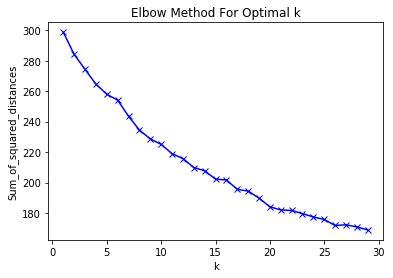

In [73]:
grouped_clustering = grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1, 30)
for kclusters in K:
    km = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Silhouette score method to determine the number of clusters

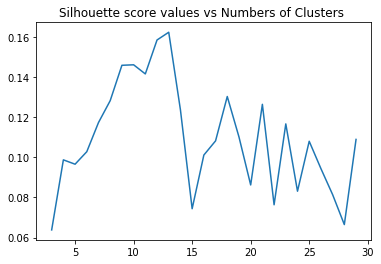

Optimal number of components is:
13


In [74]:
import numpy as numpy
import sklearn
import matplotlib.pyplot as plt
 
obs = grouped_clustering.copy() 
# obs = numpy.concatenate( (numpy.random.randn(100, 2) , 20 + numpy.random.randn(300, 2) , -15+numpy.random.randn(200, 2)))
silhouette_score_values=list()
 
NumberOfClusters=range(3,30)
 
for i in NumberOfClusters:
    
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=10)
    classifier.fit(obs)
    labels= classifier.predict(obs)
#     print("Number Of Clusters:")
#     print(i)
#     print("Silhouette score value")
#     print(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', random_state=0))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()
 
Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)

#### So from above two ways to determine the number of clusters, it is clear that 13 is optimum.

In [75]:
# set number of clusters
kclusters = 13

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 1,  3, 10,  1,  4,  1, 10,  1,  8,  1], dtype=int32)

In [76]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

merged = df_f

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

merged.head() # check the last columns!

Borough                                 Neighborhood Latitude  \
0        North York                                    Parkwoods  43.7533   
1        North York                             Victoria Village  43.7259   
2  Downtown Toronto                    Regent Park, Harbourfront  43.6543   
3        North York             Lawrence Manor, Lawrence Heights  43.7185   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.6623   

  Longitude  ClusterLabels 1st Most Common Venue 2nd Most Common Venue  \
0  -79.3297           11.0                  Park              Bus Stop   
1  -79.3156            1.0           Pizza Place          Hockey Arena   
2  -79.3606            1.0           Coffee Shop                Bakery   
3  -79.4648            1.0        Clothing Store     Accessories Store   
4  -79.3895            1.0           Coffee Shop                 Diner   

    3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0       Food & Drink Shop    Empanada Restaurant    English Restaurant   
1             Coffee Shop  Portuguese Restaurant           Zoo Exhibit   
2                    Park                    Pub        Breakfast Spot   
3  Furniture / Home Store            Event Space    Miscellaneous Shop   
4                    Bank            Art Gallery            Hobby Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   Ethiopian Restaurant           Event Space               Exhibit   
1                Factory  Fast Food Restaurant        Farmers Market   
2                Theater                  Café            Restaurant   
3  Vietnamese Restaurant              Boutique           Coffee Shop   
4     College Auditorium                  Park        Sandwich Place   

  9th Most Common Venue 10th Most Common Venue  
0   Filipino Restaurant             Eye Doctor  
1                  Farm     Falafel Restaurant  
2    Mexican Restaurant  Performing Arts Venue  
3           Zoo Exhibit         Farmers Market  
4                   Bar                Theater

In [77]:
merged=merged.dropna()

In [78]:
merged['ClusterLabels'] = merged.ClusterLabels.astype(int)
merged.head()

Borough                                 Neighborhood Latitude  \
0        North York                                    Parkwoods  43.7533   
1        North York                             Victoria Village  43.7259   
2  Downtown Toronto                    Regent Park, Harbourfront  43.6543   
3        North York             Lawrence Manor, Lawrence Heights  43.7185   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.6623   

  Longitude  ClusterLabels 1st Most Common Venue 2nd Most Common Venue  \
0  -79.3297             11                  Park              Bus Stop   
1  -79.3156              1           Pizza Place          Hockey Arena   
2  -79.3606              1           Coffee Shop                Bakery   
3  -79.4648              1        Clothing Store     Accessories Store   
4  -79.3895              1           Coffee Shop                 Diner   

    3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0       Food & Drink Shop    Empanada Restaurant    English Restaurant   
1             Coffee Shop  Portuguese Restaurant           Zoo Exhibit   
2                    Park                    Pub        Breakfast Spot   
3  Furniture / Home Store            Event Space    Miscellaneous Shop   
4                    Bank            Art Gallery            Hobby Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   Ethiopian Restaurant           Event Space               Exhibit   
1                Factory  Fast Food Restaurant        Farmers Market   
2                Theater                  Café            Restaurant   
3  Vietnamese Restaurant              Boutique           Coffee Shop   
4     College Auditorium                  Park        Sandwich Place   

  9th Most Common Venue 10th Most Common Venue  
0   Filipino Restaurant             Eye Doctor  
1                  Farm     Falafel Restaurant  
2    Mexican Restaurant  Performing Arts Venue  
3           Zoo Exhibit         Farmers Market  
4                   Bar                Theater

In [80]:
from project_lib import Project
project = Project(None,"17935bf7-6a8c-42b3-80cc-e76b1541fcf6","p-023e58cfc0cc5a6533dc238ddb600732dcfe5790")
df_ca,df_ny,df_blr,df_hyd,df_bom,df_pnq,df_del,df_par,df_ldn,df_sh,df_bj
project.save_data(file_name = "df_f.csv",data = df_f.to_csv(index=False))
project.save_data(file_name = "df_ca.csv",data = df_ca.to_csv(index=False))
project.save_data(file_name = "df_ny.csv",data = df_ny.to_csv(index=False))
project.save_data(file_name = "df_blr.csv",data = df_blr.to_csv(index=False))
project.save_data(file_name = "df_hyd.csv",data = df_hyd.to_csv(index=False))
project.save_data(file_name = "df_bom.csv",data = df_bom.to_csv(index=False))
project.save_data(file_name = "df_pnq.csv",data = df_pnq.to_csv(index=False))
project.save_data(file_name = "df_del.csv",data = df_del.to_csv(index=False))
project.save_data(file_name = "df_par.csv",data = df_par.to_csv(index=False))
project.save_data(file_name = "df_ldn.csv",data = df_ldn.to_csv(index=False))
project.save_data(file_name = "df_sh.csv",data = df_sh.to_csv(index=False))
project.save_data(file_name = "df_bj.csv",data = df_bj.to_csv(index=False))
project.save_data(file_name = "venues.csv",data = venues.to_csv(index=False))
project.save_data(file_name = "merged.csv",data = merged.to_csv(index=False))

{'file_name': 'merged.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'courseracapstone-donotdelete-pr-r9xn3yrbsvqhuo',
 'asset_id': '9b258eed-bc16-4de7-81bb-bd29dcd48a45'}

In [81]:
# create map
map_clusters = folium.Map()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### So now let us see each cluster indivisually

In [82]:
#indivisual cluster distribution
merged.ClusterLabels.value_counts()

1     836
10    124
9      67
8      66
11     33
6      33
4      18
3      17
2      13
0      12
12      9
5       8
7       4
Name: ClusterLabels, dtype: int64

In [90]:
# create map
def map_func(dff):
    
    map_clusters = folium.Map()

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(dff['Latitude'], dff['Longitude'], dff['Neighborhood'], dff['ClusterLabels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return(map_clusters)

In [96]:
#Cluster 0
dff=merged.loc[merged['ClusterLabels'] == 0]
display(map_func(dff))
print("Cluster 0")
merged.loc[merged['ClusterLabels'] == 0, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 0


Neighborhood 1st Most Common Venue  \
262    Anandnagar Bangalore,H.A. Farm,Hebbal Kempapura           Bus Station   
324                                        Chudenapura           Bus Station   
337        Kumbalagodu,Kumbalgodu Gollahalli,Ramohalli           Bus Station   
343  Bagalgunte,Chikkabidarkal,Nagasandra Bangalore...           Bus Station   
624                                        Ambegaon BK           Bus Station   
625                                             Katraj           Bus Station   
697  Belawadi,Bhavaninagar Pune,Bori,Kazad,Kuravali...           Bus Station   
698                            Dhekalwadi,Katyachiwadi           Bus Station   
733                                           Gulunche           Bus Station   
734                   Khandobachi Wadi,Nimbut,Nira R S           Bus Station   
800                                           Naharpur                  Café   
801  Prashant Vihar,Rithala,Rohini sec 11,Rohini Se...                  Café   

             2nd Most Common Venue 3rd Most Common Venue  \
262  Vegetarian / Vegan Restaurant                 Hotel   
324              Indian Restaurant           Zoo Exhibit   
337                    Zoo Exhibit    Falafel Restaurant   
343                     Restaurant           Zoo Exhibit   
624                           Lake                  Farm   
625                           Lake                  Farm   
697                    Zoo Exhibit    Falafel Restaurant   
698                    Zoo Exhibit    Falafel Restaurant   
733                    Zoo Exhibit    Falafel Restaurant   
734                    Zoo Exhibit    Falafel Restaurant   
800                    Bus Station                  Farm   
801                    Bus Station                  Farm   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
262     Indian Restaurant               Factory                 Field   
324    Falafel Restaurant   Filipino Restaurant                 Field   
337   Filipino Restaurant                 Field  Fast Food Restaurant   
343           Film Studio                 Field  Fast Food Restaurant   
624           Zoo Exhibit    Falafel Restaurant                 Field   
625           Zoo Exhibit    Falafel Restaurant                 Field   
697   Filipino Restaurant                 Field  Fast Food Restaurant   
698   Filipino Restaurant                 Field  Fast Food Restaurant   
733   Filipino Restaurant                 Field  Fast Food Restaurant   
734   Filipino Restaurant                 Field  Fast Food Restaurant   
800           Film Studio   Filipino Restaurant                 Field   
801           Film Studio   Filipino Restaurant                 Field   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
262  Fast Food Restaurant        Farmers Market                  Farm   
324  Fast Food Restaurant        Farmers Market                  Farm   
337        Farmers Market                  Farm               Factory   
343        Farmers Market                  Farm    Falafel Restaurant   
624  Fast Food Restaurant        Farmers Market               Factory   
625  Fast Food Restaurant        Farmers Market               Factory   
697        Farmers Market                  Farm               Factory   
698        Farmers Market                  Farm               Factory   
733        Farmers Market                  Farm               Factory   
734        Farmers Market                  Farm               Factory   
800  Fast Food Restaurant        Farmers Market    Falafel Restaurant   
801  Fast Food Restaurant        Farmers Market    Falafel Restaurant   

         10th Most Common Venue  
262          Falafel Restaurant  
324                     Factory  
337  Financial or Legal Service  
343                     Factory  
624                 Film Studio  
625                 Film Studio  
697  Financial or Legal Service  
698  Financial or Legal Service  
733  Financial

In [97]:
#Cluster 1
dff=merged.loc[merged['ClusterLabels'] == 1]
display(map_func(dff))
print("Cluster 1")
merged.loc[merged['ClusterLabels'] == 1, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 1


Neighborhood  \
1                                      Victoria Village   
2                             Regent Park, Harbourfront   
3                      Lawrence Manor, Lawrence Heights   
4           Queen's Park, Ontario Provincial Government   
7                                             Don Mills   
8                       Parkview Hill, Woodbine Gardens   
9                              Garden District, Ryerson   
10                                            Glencairn   
11    West Deane Park, Princess Gardens, Martin Grov...   
12               Rouge Hill, Port Union, Highland Creek   
13                                            Don Mills   
14                                     Woodbine Heights   
15                                       St. James Town   
16                                   Humewood-Cedarvale   
17    Eringate, Bloordale Gardens, Old Burnhamthorpe...   
18                    Guildwood, Morningside, West Hill   
19                                          The Beaches   
20                                          Berczy Park   
22                                               Woburn   
23                                              Leaside   
24                                   Central Bay Street   
25                                             Christie   
26                                            Cedarbrae   
27                                    Hillcrest Village   
28      Bathurst Manor, Wilson Heights, Downsview North   
29                                     Thorncliffe Park   
30                             Richmond, Adelaide, King   
31                         Dufferin, Dovercourt Village   
32                                  Scarborough Village   
33                         Fairview, Henry Farm, Oriole   
...                                                 ...   
1338                                         Dongzhimen   
1340                                            Qianmen   
1343                                           Tiyuguan   
1344                                            Tiantan   
1347                                          Xingcheng   
1348                                               Xilu   
1350                                        Zhoukoudian   
1353                                            Doudian   
1365                                          Dahongmen   
1367                                          Lugouqiao   
1368                                            Majiapu   
1370                                            Wangzuo   
1372                                       Wanpingcheng   
1381                                   Beitaipingzhuang   
1382                                       Xueyuan Road   
1383                                       Zhongguancun   
1388                                       Huayuan Road   
1389                                            Xisanqi   
1390                                           Malianwa   
1393                                             Wanliu   
1394                                          Dongsheng   
1395                                            Wenquan   
1396                                          Xibeiwang   
1400                                              Yanqi   
1405                                            Huaibei   
1410                                            Jinrong   
1411                                      West Chang'an   
1415                                          Shichahai   
1416                                           Tianqiao   
1420                                     Guang'anmenwai   

          1st Most Common Venue       2nd Most Common Venue  \
1                   Pizza Place                Hockey Arena   
2                   Coffee Shop                      Bakery   
3                Clothing Store           Accessories Store   
4                   Coffee Shop                       Diner   
7                           Gym         Japanese Restaurant   
8     

In [98]:
#Cluster 2
dff=merged.loc[merged['ClusterLabels'] == 2]
display(map_func(dff))
print("Cluster 2")
merged.loc[merged['ClusterLabels'] == 2, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 2


Neighborhood 1st Most Common Venue  \
523   Airport Mumbai,International Airport,Sahar P &...                 Hotel   
579                                Dharavi Road,Dharavi                 Hotel   
1132                                           Yanghang                 Hotel   
1136                                             Haiwan                 Hotel   
1155                                             Shihua                 Hotel   
1195                                             Heqing                 Hotel   
1200                                            Nicheng                 Hotel   
1206                                           Xuanqiao                 Hotel   
1269                                          Changxing                 Hotel   
1276                                       Qianwei Farm                 Hotel   
1311                                             Dongba                 Hotel   
1375                                       Wanshou Road                 Hotel   
1385                                        Qinghuayuan                 Hotel   

     2nd Most Common Venue 3rd Most Common Venue       4th Most Common Venue  \
523                   Café                   Gym          Falafel Restaurant   
579                Factory   Filipino Restaurant                       Field   
1132         Big Box Store           Coffee Shop  Financial or Legal Service   
1136               Factory   Filipino Restaurant                       Field   
1155               Factory   Filipino Restaurant                       Field   
1195               Factory   Filipino Restaurant                       Field   
1200               Factory   Filipino Restaurant                       Field   
1206               Factory   Filipino Restaurant                       Field   
1269               Factory   Filipino Restaurant                       Field   
1276               Factory   Filipino Restaurant                       Field   
1311         Grocery Store    Falafel Restaurant         Filipino Restaurant   
1375    Chinese Restaurant    Beijing Restaurant         Empanada Restaurant   
1385           Flea Market     Convenience Store                     Factory   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
523                  Field  Fast Food Restaurant        Farmers Market   
579   Fast Food Restaurant        Farmers Market                  Farm   
1132   Filipino Restaurant                 Field  Fast Food Restaurant   
1136  Fast Food Restaurant        Farmers Market                  Farm   
1155  Fast Food Restaurant        Farmers Market                  Farm   
1195  Fast Food Restaurant        Farmers Market                  Farm   
1200  Fast Food Restaurant        Farmers Market                  Farm   
1206  Fast Food Restaurant        Farmers Market                  Farm   
1269  Fast Food Restaurant        Farmers Market                  Farm   
1276  Fast Food Restaurant        Farmers Market                  Farm   
1311                 Field  Fast Food Restaurant        Farmers Market   
1375    English Restaurant  Ethiopian Restaurant           Event Space   
1385                 Field  Fast Food Restaurant        Farmers Market   

     8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  
523                   Farm               Factory                  Film Studio  
579     Falafel Restaurant            Eye Doctor          EV Charging Station  
1132        Farmers Market                  Farm           Falafel Restaurant  
1136    Falafel Restaurant            Eye Doctor          EV Charging Station  
1155    Falafel Restaurant            Eye Doctor          EV Charging Station  
1195    Falafel Restaurant            Eye Doctor          EV Charging Station  
1200    Falafel Restaurant            Eye Doctor          EV Charging Station  
1206    Falafel Restaurant            Eye Doctor          EV Charging Station  
1269    Falafel Restaurant    

In [99]:
#Cluster 3
dff=merged.loc[merged['ClusterLabels'] == 3]
display(map_func(dff))
print("Cluster 3")
merged.loc[merged['ClusterLabels'] == 3, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 3


Neighborhood 1st Most Common Venue  \
258         A F Station Yelahanka,BSF Campus Yelahanka                   ATM   
306  Banashankari III Stage,Girinagar Bangalore,Kat...                   ATM   
406                                 Ibrahim Bagh Lines                   ATM   
421                                        Bahadurpura                   ATM   
422                     Hussainialam,Kishanbagh,Tadbun                   ATM   
431                                    Don Bosco Nagar                   ATM   
454                                        Saroornagar                   ATM   
475                                 Balanagar Township                   ATM   
476                       CIE Balangar,Rangareddynagar                   ATM   
612                                          Kasarwadi                   ATM   
648                 Kudje,Mandvi BK,Shivane,Uttamnagar                   ATM   
649                                 N.D.A. Khadakwasla                   ATM   
762                      Phursungi,Uruli Devachi,Vadki                   ATM   
820                      Badusarai,Chhawla,Kangan Heri                   ATM   
821                                           DC Goyla                   ATM   
830  Ashok Nagar West Delhi,Chand Nagar,Chaukhandi,...                   ATM   
833  D. K. Mohan Garden,Hastal Village,Jeevan Park,...                   ATM   

          2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
258  Financial or Legal Service   Empanada Restaurant    English Restaurant   
306                    Mountain        Ice Cream Shop               Factory   
406  Financial or Legal Service   Empanada Restaurant    English Restaurant   
421  Financial or Legal Service   Empanada Restaurant    English Restaurant   
422  Financial or Legal Service   Empanada Restaurant    English Restaurant   
431  Financial or Legal Service   Empanada Restaurant    English Restaurant   
454            Business Service    Falafel Restaurant   Filipino Restaurant   
475  Financial or Legal Service   Empanada Restaurant    English Restaurant   
476  Financial or Legal Service   Empanada Restaurant    English Restaurant   
612  Financial or Legal Service   Empanada Restaurant    English Restaurant   
648  Financial or Legal Service   Empanada Restaurant    English Restaurant   
649  Financial or Legal Service   Empanada Restaurant    English Restaurant   
762  Financial or Legal Service   Empanada Restaurant    English Restaurant   
820  Financial or Legal Service   Empanada Restaurant    English Restaurant   
821  Financial or Legal Service   Empanada Restaurant    English Restaurant   
830              Clothing Store     Electronics Store   Empanada Restaurant   
833  Financial or Legal Service   Empanada Restaurant    English Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
258  Ethiopian Restaurant           Event Space               Exhibit   
306   Filipino Restaurant                 Field  Fast Food Restaurant   
406  Ethiopian Restaurant           Event Space               Exhibit   
421  Ethiopian Restaurant           Event Space               Exhibit   
422  Ethiopian Restaurant           Event Space               Exhibit   
431  Ethiopian Restaurant           Event Space               Exhibit   
454                 Field  Fast Food Restaurant        Farmers Market   
475  Ethiopian Restaurant           Event Space               Exhibit   
476  Ethiopian Restaurant           Event Space               Exhibit   
612  Ethiopian Restaurant           Event Space               Exhibit   
648  Ethiopian Restaurant           Event Space               Exhibit   
649  Ethiopian Restaurant           Event Space               Exhibit   
762  Ethiopian Restaurant           Event Space               Exhibit   
820  Ethiopian Restaurant           Event Space               Exhibit   
821  Ethiopian Restaurant           Event Space               Exhibit   
830    Eng

In [100]:
#Cluster 4
dff=merged.loc[merged['ClusterLabels'] == 4]
display(map_func(dff))
print("Cluster 4")
merged.loc[merged['ClusterLabels'] == 4, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 4


Neighborhood  \
279     Doddagubbi,Dr. Shivarama Karanth Nagar,Kothanur   
321                                          Chandapura   
330                      Electronics City,Wipro Limited   
383                        Dasanapura,Madanayakanahalli   
385   A.Gs Office,Anandnagar Hyderabad,Bazarghat Hyd...   
386                                    Parishram Bhawan   
387                              Vidhan Sabha Hyderabad   
465               Alwal,Bolarum Bazar,Bolarum,Haiglines   
466                                             Kowkoor   
469   Ankireddipalli,Ankushapur,Bogaram,Cherial,Cher...   
495     Katchavanisingaram,Rajeevagruhakalpa,Samskruthi   
496                             Korremal,Pratapsingaram   
509                                          Sainikpuri   
620                                             Sangavi   
627                                            Armament   
628                                         Bavdhan,Sus   
1306                                        Sanjianfang   
1349                                         Liangxiang   

        1st Most Common Venue       2nd Most Common Venue  \
279                      Café        Karnataka Restaurant   
321                      Café  Financial or Legal Service   
330   Fruit & Vegetable Store                        Café   
383                      Café  Financial or Legal Service   
385                      Café                      Bakery   
386                      Café                      Bakery   
387                      Café                      Bakery   
465                      Café  Financial or Legal Service   
466                      Café  Financial or Legal Service   
469                       ATM                        Café   
495                       ATM                        Café   
496                       ATM                        Café   
509                      Café          Falafel Restaurant   
620                      Café  Financial or Legal Service   
627                      Café                      Resort   
628                      Café                      Resort   
1306                     Café               Metro Station   
1349                     Café               Metro Station   

           3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
279           Falafel Restaurant   Filipino Restaurant                 Field   
321          Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
330            Electronics Store   Empanada Restaurant    English Restaurant   
383          Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
385                       Market           Zoo Exhibit    Falafel Restaurant   
386                       Market           Zoo Exhibit    Falafel Restaurant   
387                       Market           Zoo Exhibit    Falafel Restaurant   
465          Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
466          Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
469          Fried Chicken Joint           Film Studio   Empanada Restaurant   
495          Fried Chicken Joint           Film Studio   Empanada Restaurant   
496          Fried Chicken Joint           Film Studio   Empanada Restaurant   
509   Financial or Legal Service   Empanada Restaurant    English Restaurant   
620          Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
627                        Field  Fast Food Restaurant        Farmers Market   
628                        Field  Fast Food Restaurant        Farmers Market   
1306          Chinese Restaurant    Falafel Restaurant   Filipino Restaurant   
1349          Falafel Restaurant   Filipino Restaurant                 Field   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
279   Fast Food Restaurant        Farmers Market                  Farm   
321            Event Space               Exhibit            Eye Doctor   
330   Ethiopian Re

In [101]:
#Cluster 5
dff=merged.loc[merged['ClusterLabels'] == 5]
display(map_func(dff))
print("Cluster 5")
merged.loc[merged['ClusterLabels'] == 5, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 5


Neighborhood 1st Most Common Venue  \
319                                          Carmelram     Mobile Phone Shop   
492                                       HMT Township     Mobile Phone Shop   
658             Agoti,Dalaj,Loni Deokar,Nhavi,Palasdeo     Mobile Phone Shop   
681  Amondi,Ghodegaon Pune,Girawali,Pimpalgaon Tarf...     Mobile Phone Shop   
689  Avasari BK,Lakhangaon,Nirgudsar,Pargaon Tarfe ...     Mobile Phone Shop   
695  Bawada,Bhandgaon,Bhodani,Lakhewadi,Pimpri BK,S...     Mobile Phone Shop   
699  Belsar,Javalarjun,Jejuri,Kolvihire,Kothale,Mav...     Mobile Phone Shop   
792  Bankner,Bhorgarh,Kanya Gurukul,Lampur,Narela,S...     Mobile Phone Shop   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
319           Zoo Exhibit    Falafel Restaurant   Filipino Restaurant   
492           Zoo Exhibit    Falafel Restaurant   Filipino Restaurant   
658           Zoo Exhibit    Falafel Restaurant   Filipino Restaurant   
681           Zoo Exhibit    Falafel Restaurant   Filipino Restaurant   
689           Zoo Exhibit    Falafel Restaurant   Filipino Restaurant   
695           Zoo Exhibit    Falafel Restaurant   Filipino Restaurant   
699           Zoo Exhibit    Falafel Restaurant   Filipino Restaurant   
792           Zoo Exhibit    Falafel Restaurant   Filipino Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
319                 Field  Fast Food Restaurant        Farmers Market   
492                 Field  Fast Food Restaurant        Farmers Market   
658                 Field  Fast Food Restaurant        Farmers Market   
681                 Field  Fast Food Restaurant        Farmers Market   
689                 Field  Fast Food Restaurant        Farmers Market   
695                 Field  Fast Food Restaurant        Farmers Market   
699                 Field  Fast Food Restaurant        Farmers Market   
792                 Field  Fast Food Restaurant        Farmers Market   

    8th Most Common Venue 9th Most Common Venue      10th Most Common Venue  
319                  Farm               Factory  Financial or Legal Service  
492                  Farm               Factory  Financial or Legal Service  
658                  Farm               Factory  Financial or Legal Service  
681                  Farm               Factory  Financial or Legal Service  
689                  Farm               Factory  Financial or Legal Service  
695                  Farm               Factory  Financial or Legal Service  
699                  Farm               Factory  Financial or Legal Service  
792                  Farm               Factory  Financial or Legal Service

In [102]:
#Cluster 6
dff=merged.loc[merged['ClusterLabels'] == 6]
display(map_func(dff))
print("Cluster 6")
merged.loc[merged['ClusterLabels'] == 6, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 6


Neighborhood 1st Most Common Venue  \
233                                        Emerson Hill         Historic Site   
597                                               C M E         Historic Site   
598                                            Chikhali         Historic Site   
599                                  Rupeenagar,Talwade         Historic Site   
608                             Infotech Park Hinjawadi         Historic Site   
609                                             Marunji         Historic Site   
610                                               Wakad         Historic Site   
621                                                Srpf         Historic Site   
629                                               Aundh         Historic Site   
630                              Aundh T.S.,Ganeshkhind         Historic Site   
659      Ala Pune,Alephata,Bori BK,Rajuri,Vadgaon Anand         Historic Site   
669   Ambade,Ambavade,Ambeghar,Apti,Bari BK,Bazarwad...         Historic Site   
685   Arvi Pune,Gunjalwadi,Pimpalgaon Tarfa Narayang...         Historic Site   
686   Ashtapur,Dahitane,Kesnand,Koregaon Bhivar,Vade...         Historic Site   
687                                 Rahu,Telewadi,Walki         Historic Site   
691                                Avsari KH,Gawadewadi         Historic Site   
701   Bhamburde,Ganegaon Khalasa,Karanjawane,Kondhap...         Historic Site   
711                  Bibi,Chas Pune,Kadadhe,Tiwai Hills         Historic Site   
715   Burunjwadi,Dhanore,Hivare,Jategaon BK,Karandi,...         Historic Site   
722        Daundaj,Harni,Jeur,Mandki,Pingori,Rakh,Valha         Historic Site   
723   Dawanewadi,Hargude,Kaldari,Mahur,Mandhar,Parinche         Historic Site   
730                                 Gangapur KH,Shinoli         Historic Site   
743                                        Kaivalyadham         Historic Site   
745   Kandali,Kolvadi,Pimpalwandi Pune,Umbraj,Vadgao...         Historic Site   
747      Karegaon,Midc Ranjangaon Ganpati,Nimgaon Bhogi         Historic Site   
748               Karegaon,Pargaon Tarfe Khed,Peth Pune       Motorcycle Shop   
749                                    Kurwandi,Thugaon       Motorcycle Shop   
752                               Kolwadi,Naygaon,Theur         Historic Site   
763                                         Tondal,Veer         Historic Site   
1131                                            Songnan             Multiplex   
1224                                         Zhujiajiao         Historic Site   
1331                                           Jingshan         Historic Site   
1332                                         Donghuamen         Historic Site   

           2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
233   Construction & Landscaping                  Food            Eye Doctor   
597                Burrito Place             Multiplex                Bakery   
598                Burrito Place             Multiplex                Bakery   
599                Burrito Place             Multiplex                Bakery   
608                Burrito Place             Multiplex                Bakery   
609                Burrito Place             Multiplex                Bakery   
610                Burrito Place             Multiplex                Bakery   
621                Burrito Place             Multiplex                Bakery   
629                Burrito Place             Multiplex                Bakery   
630                Burrito Place             Multiplex                Bakery   
659                Burrito Place             Multiplex                Bakery   
669                Burrito Place             Multiplex                Bakery   
685                Burrito Place             Multiplex                Bakery   
686                Burrito Place             Multiplex                Bakery   
687                Burrito Place             Multiplex                Bakery   
691     

In [103]:
#Cluster 7
dff=merged.loc[merged['ClusterLabels'] == 7]
display(map_func(dff))
print("Cluster 7")
merged.loc[merged['ClusterLabels'] == 7, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 7


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
427  Crp Camp Hyderabad,Keshogiri      Stationery Store           Zoo Exhibit   
428                   Mamidipalli      Stationery Store           Zoo Exhibit   
443                    Kismathpur      Stationery Store           Zoo Exhibit   
444  Rajendranagar K.V.Rangareddy      Stationery Store           Zoo Exhibit   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
427            Eye Doctor                 Field  Fast Food Restaurant   
428            Eye Doctor                 Field  Fast Food Restaurant   
443            Eye Doctor                 Field  Fast Food Restaurant   
444            Eye Doctor                 Field  Fast Food Restaurant   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
427        Farmers Market                  Farm    Falafel Restaurant   
428        Farmers Market                  Farm    Falafel Restaurant   
443        Farmers Market                  Farm    Falafel Restaurant   
444        Farmers Market                  Farm    Falafel Restaurant   

    9th Most Common Venue 10th Most Common Venue  
427               Factory                Exhibit  
428               Factory                Exhibit  
443               Factory                Exhibit  
444               Factory                Exhibit

In [104]:
#Cluster 8
dff=merged.loc[merged['ClusterLabels'] == 8]
display(map_func(dff))
print("Cluster 8")
merged.loc[merged['ClusterLabels'] == 8, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 8


Neighborhood  \
39                                      Bayview Village   
295                   Jeevanbhimanagar,New Thippasandra   
389                                AP Police Academy PO   
390                                       Hydershahkote   
412                                Raj Bhawan Hyderabad   
415                                     Srinagar Colony   
433                           Fatehdarwaza,Shahalibanda   
438                                Hindustan Cables Ltd   
450                                        Peerzadiguda   
464                                         Allampalli.   
473   Ashoknagar Hyderabad,Golconda Chowrastha,Mushe...   
474                                Musheerabad Delivery   
511                                           Vikarabad   
615          Masulkar Colony,Nehrunagar Pune,Pimpri P F   
640                                          Dhankawadi   
646           Kasba Peth,Mangalwar Peth Pune,Rasta Peth   
799   Mangolpuri A Block,Mangolpuri I Block,Mangolpu...   
1124                                              Youyi   
1133                                              Yuepu   
1135                                          Fengcheng   
1139                                            Qingcun   
1150                                        Linfen Road   
1160                                           Shanyang   
1170                                            Meilong   
1173                                          Xinzhuang   
1189                                              Caolu   
1197                                            Jinqiao   
1199                                            Laogang   
1205                                           Xinchang   
1208                                             Zhoupu   
...                                                 ...   
1258                                           Changbai   
1261                                          Kongjiang   
1262                                     Pingliang Road   
1267                                            Yinhang   
1290                                         Balizhuang   
1298                                         Gaobeidian   
1300                                        Taiyanggong   
1301                                        Xiaohongmen   
1304                                       Laiguangying   
1314                                         Wangsiying   
1339                                           Hepingli   
1342                                            Longtan   
1345                                     Yongdingmenwai   
1354                                          Changyang   
1356                                          Zhangfang   
1361                                            Fengtai   
1362                                           Youanmen   
1363                                        Taipingqiao   
1371                                         Fangzhuang   
1378                                          Ganjiakou   
1379                                         Balizhuang   
1380                                          Zizhuyuan   
1404                                             Qiaozi   
1407                                              Bohai   
1412                                          Xinjiekou   
1413                                             Yuetan   
1414                                       Zhanlan Road   
1417                                         Taoranting   
1419                                             Niujie   
1422                                            Guoyuan   

       1st Most Common Venue      2nd Most Common Venue  \
39        Chinese Restaurant                       Bank   
295              Pizza Place                 Restaurant   
389              Music Venue                Zoo Exhibit   
390              Music Venue                Zoo Exhibit   
412              Music Venue                Zoo Exhibit   
415                   Bakery  

In [105]:
#Cluster 9
dff=merged.loc[merged['ClusterLabels'] == 9]
display(map_func(dff))
print("Cluster 9")
merged.loc[merged['ClusterLabels'] == 9, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 9


Neighborhood 1st Most Common Venue  \
6                                        Malvern, Rouge  Fast Food Restaurant   
252                                     Richmond Valley  Fast Food Restaurant   
299                  P&T Col. Kavalbyrasandra,R T Nagar                  Park   
338                                        Nayandahalli                   ATM   
354                                      Jalahalli West             BBQ Joint   
369                     Yeshwanthpur Bazar,Yeswanthpura  Fast Food Restaurant   
376                                         Bettahalsur                 Hotel   
377   Chikkajala,Doddajala,Hunasamaranahalli,Tarahun...                 Hotel   
455                                              Svpnpa             Multiplex   
460                       Airforce Academy,Bahadurpalli   Fried Chicken Joint   
484   Dabirpur,Girmapur,Gowdavalli,Nutankal,Rajbolar...   Fried Chicken Joint   
494                        Jntu Kukat Pally,KPHB Colony  Fast Food Restaurant   
507                                            Nizampet  Fast Food Restaurant   
508                                        Pragatinagar  Fast Food Restaurant   
518                Kidwai Nagar Mumbai,Wadala Rs,Wadala  Fast Food Restaurant   
548   Bangur Nagar,Goregaon RS,Goregaon Mumbai,Motil...           Flea Market   
560                                     Jogeshwari East                  Café   
583                                        Malabar Hill  Fast Food Restaurant   
603                                 Dapodi Bazar,Dapodi  Fast Food Restaurant   
605                                      Gondhale Nagar           Snack Place   
606                                Hadapsar,Sasanenagar           Snack Place   
635   Bhavani Peth,Ghorpade Peth,Guruwar Peth,Swarga...                   ATM   
636        Bhusari Colony,Ex. Serviceman Colony,Kothrud  Fast Food Restaurant   
796   Ganeshpura,Keshav Puram North West Delhi,Onkar...     Electronics Store   
822              Bagdola,Barthal,Dhulsiras,Raj Nagar II  Fast Food Restaurant   
827                             Kakrola,N.S.I.T. Dwarka  Fast Food Restaurant   
835   Delhi Industrial Area,ESI,Karam Pura,L. M. Nag...  Fast Food Restaurant   
927                                       Anerley,Penge           Supermarket   
1017                                       East Dulwich  Fast Food Restaurant   
1125                                          Zhangmiao         Metro Station   
...                                                 ...                   ...   
1181                                           Nanmatou    Chinese Restaurant   
1188                                             Beicai           Bus Station   
1190                                           Chuansha                  Park   
1192                                            Gaohang         Big Box Store   
1193                                            Gaoqiao                 Hotel   
1201                                             Sanlin  Fast Food Restaurant   
1215                                            Xiayang  Fast Food Restaurant   
1229                                            Yueyang           Bus Station   
1233                                            Jiuting  Fast Food Restaurant   
1237                                             Sijing        Scenic Lookout   
1247                                       Hongmei Road            Theme Park   
1250                                       Lingyun Road  Fast Food Restaurant   
1254                                         Xietu Road                Bakery   
1256                                            Huajing  Fast Food Restaurant   
1266                                              Yanji             Rock Club   
1281                                       Zuojiazhuang  Fast Food Restaurant   
1295                                              Datun  Fast Food Restaurant   
1307                                         Guanzhuang         Metro Stat

In [106]:
#Cluster 10
dff=merged.loc[merged['ClusterLabels'] == 10]
display(map_func(dff))
print("Cluster 10")
merged.loc[merged['ClusterLabels'] == 10, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 10


Neighborhood 1st Most Common Venue  \
65    Dorset Park, Wexford Heights, Scarborough Town...     Indian Restaurant   
263                       Arabic College,Venkateshapura     Indian Restaurant   
264   Attur,CRPF Campus Yelahanka,Jakkur,Rajanakunte...           Snack Place   
267       Banaswadi,Horamavu,Jalavayuvihar,Kalyananagar  Fast Food Restaurant   
274                                     C.V.Raman Nagar     Indian Restaurant   
281                                              Domlur     Indian Restaurant   
283                                                EPIP     Indian Restaurant   
284                                          Whitefield     Indian Restaurant   
287                                              Gunjur   Indie Movie Theater   
288                                  Muthusandra,Vartur   Indie Movie Theater   
289                        H.A.L II Stage,Hulsur Bazaar     Indian Restaurant   
290                                         H.K.P. Road                  Café   
291                                  Hoodi,Mahadevapura     Indian Restaurant   
292                               Indiranagar Bangalore    Chinese Restaurant   
293   ISRO Anthariksha Bhavan,R.M.V. Extension II Stage     Indian Restaurant   
297                                   Maruthi Sevanagar     Food & Drink Shop   
298                                      NAL,Vimanapura     Indian Restaurant   
300                                      Sadashivanagar     Indian Restaurant   
307                      Bangalore Corporation Building     Indian Restaurant   
308                                      Bangalore City     Indian Restaurant   
309   Bannerghatta Road,Hulimavu,JP Nagar VIII phase...     Indian Restaurant   
310                                            Hulimavu     Indian Restaurant   
311                              Bannerghatta,Gottigere      Department Store   
312                                           Ragihalli      Department Store   
313             Basavanagudi,Mavalli,Pampamahakavi Road     Indian Restaurant   
314                                      Thyagarajnagar     Indian Restaurant   
316               Bnagalore Viswavidalaya,Mallathahalli                Lounge   
320                                Chamrajpet Bangalore     Indian Restaurant   
322                                            Chickpet     Indian Restaurant   
323                       Chikkalasandra,Subramanyapura      Department Store   
...                                                 ...                   ...   
613           Khondhwa KH,Kondhwa BK,Kondhwa Lh,N I B M     Indian Restaurant   
614                                            Lohogaon     Indian Restaurant   
623           A.R. Shala,Deccan Gymkhana,Film Institute     Indian Restaurant   
645                              Karvenagar,Navsahyadri                  Café   
647                                    Khadakwasla R.S.     Indian Restaurant   
650   Lokmanyanagar,Narayan Peth,Rashtra Bhasha Bhav...     Indian Restaurant   
651                                Parvati Gaon,Parvati                  Café   
660   Alande,Anantnagar Nigade,Bhongavali,Dhangavadi...             Rest Area   
661   ArviHaveli,GogalwadiE,Kalyan,Khed Shivapur,Khe...             Rest Area   
662                                           Ketkavale             Rest Area   
663   Alandi Chorachi,Kadam Wak Wasti,Kunjirwadi,Lon...     Indian Restaurant   
672   Ambarvet,Andgaon,Bhugaon,Bhukum,Ghotavade,Kham...     Indian Restaurant   
673                                             Sangrun     Indian Restaurant   
740                                    Kadethan,Varvand     Mobile Phone Shop   
766   Anand Parbat Indl. Area,Anand Parbat,Bank Stre...     Indian Restaurant   
771   Hauz Qazi,Jama Masjid,Delhi G.P.O.,Chandni Cho...     Indian Restaurant   
776                     Union Public Service Commission     Indian Restaurant   
778   F F C Okhla,C R R I South Delhi,Okhla Industri...     Indian Restaur

In [107]:
#Cluster 11
dff=merged.loc[merged['ClusterLabels'] == 11]
display(map_func(dff))
print("Cluster 11")
merged.loc[merged['ClusterLabels'] == 11, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 11


Neighborhood 1st Most Common Venue  \
0                                             Parkwoods                  Park   
21                                  Caledonia-Fairbanks                  Park   
35        East Toronto, Broadview North (Old East York)          Intersection   
49             North Park, Maple Leaf Park, Upwood Park                  Park   
61                                        Lawrence Park                  Park   
64                                               Weston                  Park   
66                                      York Mills West                  Park   
77    Kingsview Village, St. Phillips, Martin Grove ...           Pizza Place   
83                          Moore Park, Summerhill East                Lawyer   
85    Milliken, Agincourt North, Steeles East, L'Amo...                  Park   
91                                             Rosedale                  Park   
130                                        Clason Point                  Park   
184                                           Todt Hill                 Trail   
234                                       Randall Manor                  Park   
268   Bangalore Bazaar,Dr. Ambedkar Veedhi,HighCourt...            Restaurant   
269                                   CMM Court Complex            Restaurant   
303   Agara,Koramangala I Block,Koramangala,St. John...            Restaurant   
342                                     Ullalu Upanagar                  Park   
353                                           Jalahalli                  Park   
355                                         Kodigehalli            Restaurant   
363                                       Nandinilayout                  Park   
472              Aphb Colony Moulali,Ie Moulali,Moulali                  Park   
634                              Baner Road,N.C.L. Pune                  Park   
777                                         Garhi Mandu                  Park   
983     Camden Town,Chalk Farm,Primrose Hill,Somerstown                  Park   
996         Colindale,Grahame Park,The Hyde,West Hendon                  Park   
997                                           Kingsbury                  Park   
1026            Eltham,Middle Park,New Eltham,Well Hall                 Trail   
1027                                         Mottingham                 Trail   
1151                                            Pengpu                   Park   
1303                                           Pingfang                  Park   
1376                                      Yongding Road                  Park   
1384                                            Haidian                  Park   

       2nd Most Common Venue 3rd Most Common Venue  \
0                   Bus Stop     Food & Drink Shop   
21                       Bar         Women's Store   
35                      Park     Convenience Store   
49                    Bakery                 Trail   
61               Swim School              Bus Line   
64         Convenience Store           Zoo Exhibit   
66         Convenience Store           Zoo Exhibit   
77                  Bus Line        Sandwich Place   
83                     Trail            Restaurant   
85                Playground            Eye Doctor   
91                     Trail            Playground   
130            Grocery Store                  Pool   
184                     Park           Zoo Exhibit   
234                 Bus Stop          Home Service   
268                     Park      Capitol Building   
269                     Park      Capitol Building   
303                     Park      Capitol Building   
342                 Pharmacy            Eye Doctor   
353              Film Studio     Electronics Store   
355                     Park      Capitol Building   
363                   Bakery              Bus Line   
472    Performing Arts Venue               Exhibit   
634              Film Studio     Electronics S

In [108]:
#Cluster 12
dff=merged.loc[merged['ClusterLabels'] == 12]
display(map_func(dff))
print("Cluster 12")
merged.loc[merged['ClusterLabels'] == 12, merged.columns[[1] + list(range(5, merged.shape[1]))]]

Cluster 12


Neighborhood 1st Most Common Venue  \
483                                         Chandanagar         Train Station   
670             Ambale,Ambi,Induri,Umbre Navlakh,Varale         Train Station   
671                             Talegaon G H,Vishnupuri         Train Station   
784   C.C.I.,Delhi University,Gulabi Bagh,Kamla Naga...         Train Station   
802                 New Multan Nagar,Shakur Basti Depot         Train Station   
1211                                    Luchaogang Farm         Train Station   
1316                                       Linxiao Road         Train Station   
1320                                           Huangcun         Train Station   
1326                                             Anding         Train Station   

        2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
483                       ATM            Eye Doctor                 Field   
670         Indian Restaurant           Bus Station           Zoo Exhibit   
671         Indian Restaurant           Bus Station           Zoo Exhibit   
784   Health & Beauty Service           Zoo Exhibit            Eye Doctor   
802               Zoo Exhibit            Eye Doctor                 Field   
1211              Zoo Exhibit            Eye Doctor                 Field   
1316              Zoo Exhibit            Eye Doctor                 Field   
1320            Metro Station               Factory   Filipino Restaurant   
1326              Zoo Exhibit            Eye Doctor                 Field   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
483   Fast Food Restaurant        Farmers Market                  Farm   
670             Eye Doctor  Fast Food Restaurant        Farmers Market   
671             Eye Doctor  Fast Food Restaurant        Farmers Market   
784   Fast Food Restaurant        Farmers Market                  Farm   
802   Fast Food Restaurant        Farmers Market                  Farm   
1211  Fast Food Restaurant        Farmers Market                  Farm   
1316  Fast Food Restaurant        Farmers Market                  Farm   
1320                 Field  Fast Food Restaurant        Farmers Market   
1326  Fast Food Restaurant        Farmers Market                  Farm   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
483     Falafel Restaurant               Factory                Exhibit  
670                   Farm    Falafel Restaurant                Factory  
671                   Farm    Falafel Restaurant                Factory  
784     Falafel Restaurant               Factory            Event Space  
802     Falafel Restaurant               Factory                Exhibit  
1211    Falafel Restaurant               Factory                Exhibit  
1316    Falafel Restaurant               Factory                Exhibit  
1320                  Farm    Falafel Restaurant             Eye Doctor  
1326    Falafel Restaurant               Factory                Exhibit

___

### By observation of each cluster carefully, we can see that 
        - cluster 0, 3, 5 n 7 are local clusters of Indian cities
        - cluster 2, 4, 6 n 12 are clusters common among Indian and Chinese cities.
        - cluster 6 is full of Historic Site, Multiplex,Theater, Restaurant n other food shops so basically looks like a tourist place
        - rest all clusters, 1, 8, 9, 10 n 11 are universal
        
##### So if someone wants to move locally within country then they can get help from the local clusters 3,6,10,13,14 n 7.
##### And for moving across countries one can find guidance from the other universal clusters.

### Thankyou
## The End